In [8]:
!kaggle kernels output abhinand05/mnist-introduction-to-computervision-with-pytorch -p .

Output file downloaded to ./submission.csv
Kernel log downloaded to ./mnist-introduction-to-computervision-with-pytorch.log 


In [33]:
from torchsummary import summary
from torch.utils.data import DataLoader
from torch import nn
import torch

import torchvision
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights, resnet18, ResNet18_Weights

In [43]:
torchvision.datasets.PhotoTour()

torchvision.datasets.phototour.PhotoTour

In [34]:
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
train_dl = DataLoader(mnist_trainset, batch_size=64, shuffle=True)
test_dl = DataLoader(mnist_testset, batch_size=64)
mnist_trainset, mnist_testset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [ ]:
weights = ResNet18_Weights.DEFAULT
preprocess = weights.transforms()

# Apply it to the input image
#img_transformed = preprocess(img)

In [36]:
model = resnet18(num_classes=10) 
model.conv1

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [37]:
import pytorch_lightning as pl

class ResNetMNIST(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # define model and loss
        self.model = resnet18(num_classes=10)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_no):
        # implement single training step
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        return loss

    def configure_optimizers(self):
        # choose your optimizer
        return torch.optim.RMSprop(self.parameters(), lr=0.005)

In [38]:
model = ResNetMNIST()
trainer = pl.Trainer(
    max_epochs=1, # set number of epochs
    #progress_bar_refresh_rate=20 # set to >= 20 if running in Google Colab
)
trainer.fit(model, train_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/user/Projects/sandbox/computer_vision/lightning_logs

  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet           | 11.2 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.701    Total estimated model params size (MB)


Epoch 0: 100%|████████████████████████████████████████████████████████████████| 938/938 [07:15<00:00,  2.15it/s, loss=0.094, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|████████████████████████████████████████████████████████████████| 938/938 [07:15<00:00,  2.15it/s, loss=0.094, v_num=0]


In [40]:
from tqdm.autonotebook import tqdm

In [39]:
def get_prediction(x, model: pl.LightningModule):
    model.freeze() # prepares model for predicting
    probabilities = torch.softmax(model(x), dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, probabilities

In [41]:
true_y, pred_y = [], []
for batch in tqdm(iter(test_dl), total=len(test_dl)):
    x, y = batch
    true_y.extend(y)
    preds, probs = get_prediction(x, model)
    pred_y.extend(preds.cpu())


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:15<00:00, 10.34it/s]


In [42]:
from sklearn.metrics import classification_report
print(classification_report(true_y, pred_y, digits=3))

              precision    recall  f1-score   support

           0      0.950     0.998     0.973       980
           1      0.990     0.996     0.993      1135
           2      0.963     0.994     0.979      1032
           3      0.987     0.969     0.978      1010
           4      0.968     0.990     0.979       982
           5      0.992     0.966     0.979       892
           6      0.985     0.960     0.973       958
           7      0.999     0.847     0.917      1028
           8      0.992     0.961     0.976       974
           9      0.873     0.993     0.929      1009

    accuracy                          0.968     10000
   macro avg      0.970     0.968     0.968     10000
weighted avg      0.970     0.968     0.968     10000



In [82]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images[:nmax]), nrow=8).permute(1, 2, 0))
def show_batch(dl, nmax=64):
    for images, labels in dl:
        show_images(images, nmax)
        break

In [83]:
image_trainset = torchvision.datasets.CIFAR100(root='./data',
                                                download=True, 
                                                transform=transforms.ToTensor())
image_dl = DataLoader(image_trainset, batch_size=64, shuffle=True)

Files already downloaded and verified


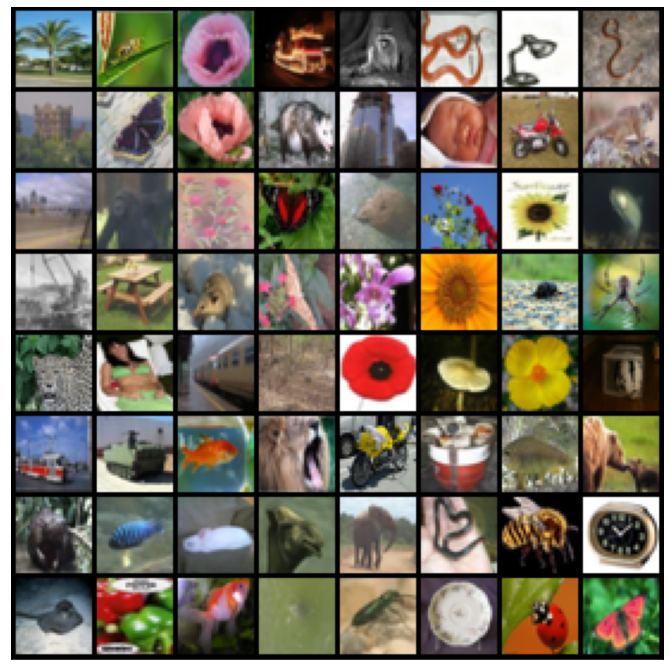

In [84]:
show_batch(image_dl)